# 1

#### En el ejemplo de teoría hemos visto la forma de entrenar utilizando un trozo de datos como en la imagen "way1.png". 

(Básicamente, tener en cuenta más datos de entrenamiento [[20% de test]])

Investiga la forma de realizar el ejercicio a partir del gif "way3_sliding_window.gif":

- ¿Da mejores resultados entrenar el modelo así?

Algo muy típico en el trabajo de data scientist

![](../rnn/sliding_windows_google.png)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback

import warnings

warnings.filterwarnings("ignore")

In [2]:
########################### SUPPORT FUNCTIONS ###########################
##### Data preprocessing
def convert_to_matrix(data, step):
    X, y =[], []

    for i in range(len(data)-step):
        d = i + step  
        X.append(data[i:d,])
        y.append(data[d,])

    return np.array(X), np.array(y)

##### Callback to pass in to the compiler
class my_callback(Callback):
    def on_epoch_end(self, epoch, logs = None):
        if (epoch + 1) % 100 == 0 and epoch > 0:
            print(f"Epoch number {epoch + 1} done")

########################### DATA MANIPULATION ###########################
##### Total time points
def data(N):
    t= np.arange(0,N)
    x= (2*np.sin(0.02*t)*np.sin(0.003*t))+0.5*np.random.normal(size=N)

    return t, x

##### Batches
def batch_calculator(t, x, batch_size):
    t_batch = t[:batch_size]
    x_batch = x[:batch_size]

    return t_batch, x_batch

# Train_test splitter
def train_test(t_batch, x_batch, split):
    split_ = round(split * len(x_batch))

    t_train, t_test = t_batch[:split_], t_batch[split_:]
    x_train, x_test = x_batch[:split_], x_batch[split_:]

    return t_train, t_test, x_train, x_test

########################### MODELING ###########################
##### Neural network
def model_creator():
    model = Sequential([
        layers.LSTM(units = 128, input_shape = (1, 4), activation = "relu"),
        layers.Dense(32, activation = "relu"),
        layers.Dense(1)
    ])

    model.compile(loss = "mean_squared_error", optimizer = RMSprop(lr = .001), metrics = ["mse"])

    return model

##### Looper
def model_trainer(model, train, test):
    # Data preprocessing
    step = 4

    train = np.append(train,np.repeat(train[-1,], step))
    test = np.append(test,np.repeat(test[-1,], step))

    X_train, y_train = convert_to_matrix(train, step)
    X_test, y_test = convert_to_matrix(test, step)

    # Reshaping to fit into the model
    X_train, X_test = X_train.reshape(len(X_train), 1, 4), X_test.reshape(len(X_test), 1, 4)

    # Model training
    model_history = model.fit(X_train, y_train, epochs = 100, batch_size = 16, callbacks = [my_callback()], verbose = 0)

    # Predictions
    train_prediction = model.predict(X_train)
    test_prediction = model.predict(X_test)

    return model_history.history, train_prediction, test_prediction

########################### DATA VISUALIZATION ###########################
# To plot everything together
def plotter(model_history, t_train, t_test, x_train, x_test, train_prediction, test_prediction):
    fig = plt.figure(figsize = (14, 8), constrained_layout=True)
    gs = fig.add_gridspec(2, 2)

    # Actual data
    ax1 = fig.add_subplot(gs[0, :-1])
    ax1.set_title('Actual data')
    ax1.plot(t_train, x_train, c = 'blue')
    ax1.plot(t_test, x_test, c = 'orange', alpha = 0.7)
    ax1.legend(['Train','Test'])
    ax1.axvline(t_train[-1], c="r")
    ax1.grid(True)

    # Predictions
    ax2 = fig.add_subplot(gs[0, -1])
    ax2.set_title('Predictions')
    ax2.plot(t_train, train_prediction, c = 'blue')
    ax2.plot(t_test, test_prediction, c = 'orange', alpha = 0.7)
    ax2.legend(['Train','Test'])
    ax2.axvline(t_train[-1], c="r")
    ax2.grid(True)

    # Loss function
    ax3 = fig.add_subplot(gs[1, :])
    ax3.set_title('RMSE loss over epochs')
    ax3.plot(np.sqrt(model_history['loss']),c='k',lw=2)
    ax3.grid(True)
    ax3.set_xlabel("Epochs",fontsize=14)
    ax3.set_ylabel("Root-mean-squared error",fontsize=14)

    return fig

Epoch number 100 done


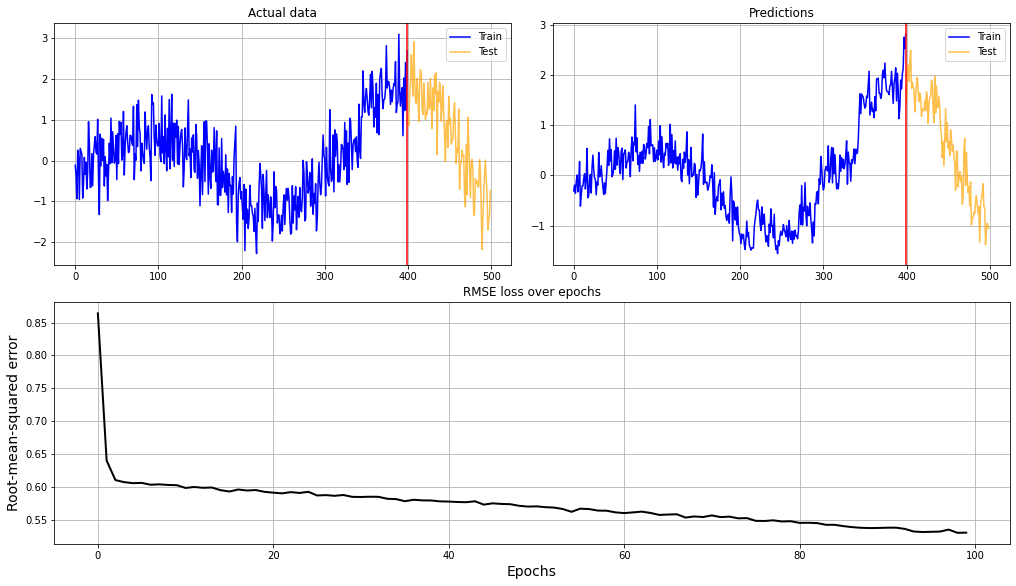

Epoch number 100 done


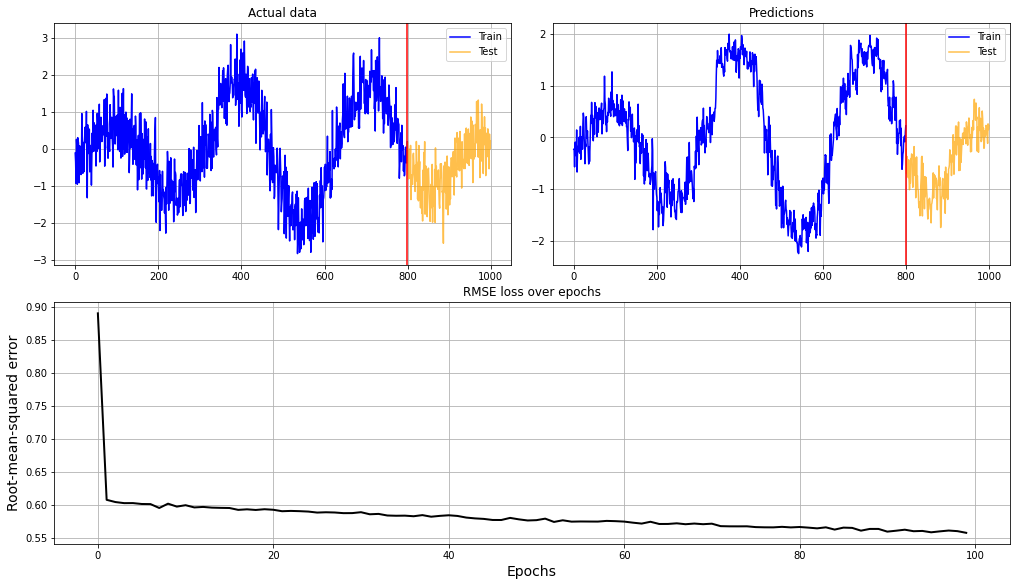

Epoch number 100 done


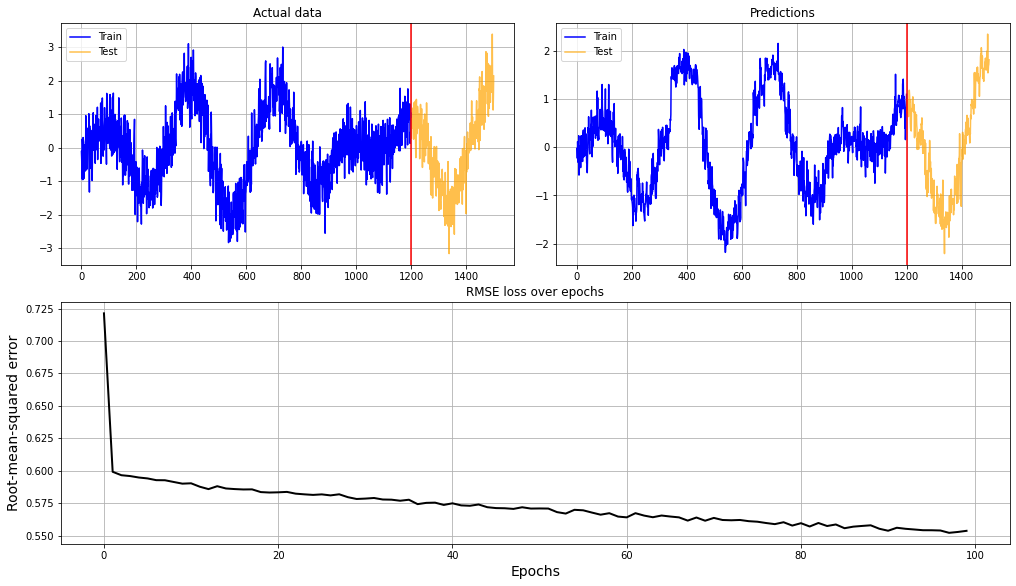

Epoch number 100 done


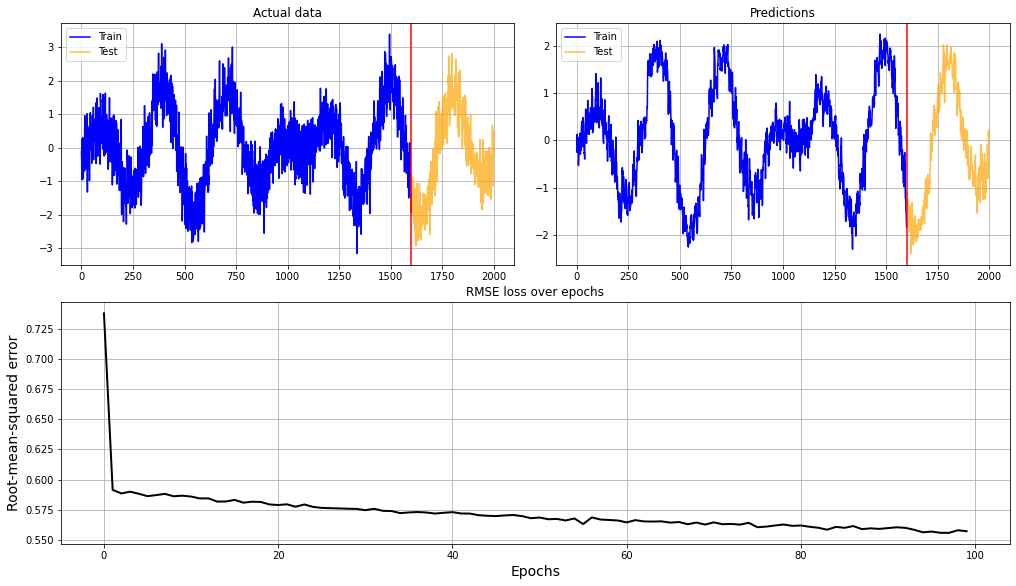

Epoch number 100 done


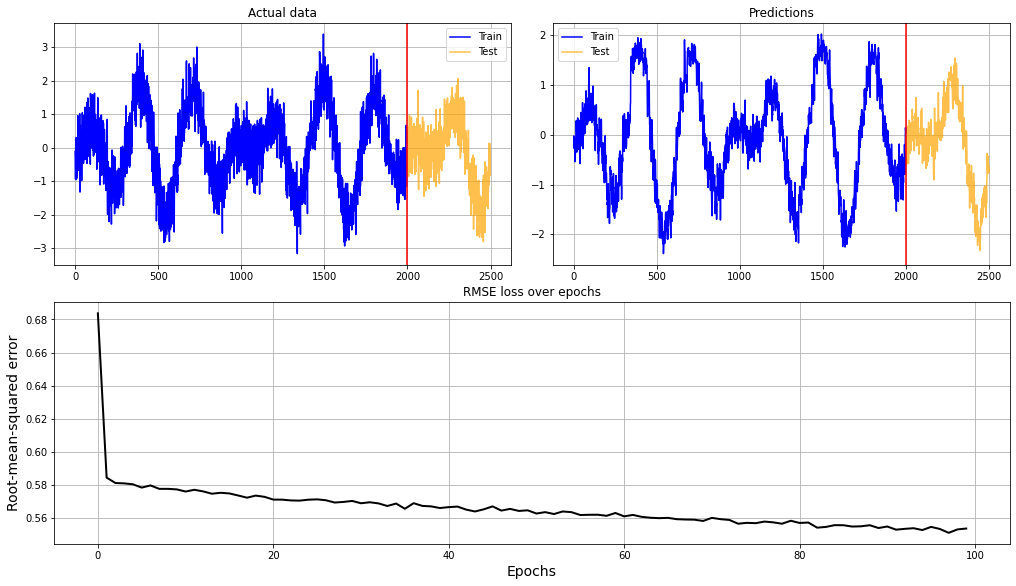

In [3]:
# Data and batches parameters
N = 3000
batch_size = 500
train_test_split = .8

# Create the data
t, x = data(N)

while batch_size < N:
    # Take the data batch
    t_batch, x_batch = batch_calculator(t, x, batch_size)

    # Split data into train and test
    t_train, t_test, x_train, x_test = train_test(t_batch, x_batch, train_test_split)

    #print("t_batch", t_batch[-1])
    #print("t_train", t_train[-1])
    # Create the model
    model = model_creator()

    # Train the model
    model_history, train_prediction, test_prediction = model_trainer(model, x_train, x_test)

    # Plot everything
    fig = plotter(model_history, t_train, t_test, x_train, x_test, train_prediction, test_prediction)
    plt.show()

    # Increase the batch size
    batch_size += 500